# Create session-level measurements

This notebook concatenates all of the measurements collected on various dates into one csv per site. The metrics consist of the following measures, with one summary statistic per session-treatment group:

- indoor air temperature (mean, std dev, quartiles)
- indoor relative humidity (mean, std dev, quartiles)
- outdoor air temperature, avg/min/max over the date of each session.
- outdoor relative humidity, avg/min/max over the date of each session.
- participant level mean T and RH, averaged over duration of session.
- operative temp in control and tx
- CO2 in control and tx

In [1]:
sys.path.append('../scripts/')
from utilities import *

import pandas as pd
from os.path import join
import pickle
import pdb

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

sns.set()
sns.set_context('talk')

idx = pd.IndexSlice

In [2]:
home_dir = '/Users/ianbolliger/Dropbox/Temperature & Behavior/Experiments'
s = Settings(home_dir)

save_fpath_berk = join(s.berk.home_dir,'session_level_environmental_data.csv')
save_fpath_bus = join(s.bus.home_dir,'session_level_environmental_data.csv')

int_data_dir = '../../data/int'

In [3]:
def calc_session_level_indoor_vals(dfs, timing_df, site_settings):
    out_df = pd.DataFrame()
    idx = pd.IndexSlice

    for grp_ix,grp in enumerate(['control','treatment']):
        grp_df = timing_df[timing_df['Treatment group']==grp_ix]

        # one dataframe for each sensor location
        loc_dfs = []
        for loc in site_settings.sens_locs + [str(i) for i in range(1,7)] + ['Top', 'co2']:
            tmp_df = dfs[grp][loc].reset_index()
            tmp_df['sess'] = pd.cut(tmp_df['time'],bins=grp_df.index)
            grouped = tmp_df.groupby('sess').describe()

            # drop pilot sessions where we don't have room-level sensors (only individual)
            grouped = grouped[grouped.loc[:,idx[:,'count']].sum(axis=1)!=0]

            # don't need # of measurements taken in session
            grouped = grouped.drop(columns='count',level=1)

            loc_dfs.append(grouped)

        # estimate average values for sessions where only one sensor recording
        # then average the sensors for each session
        room_sesh_vals = average_two_sensors(loc_dfs)

        # clarify that these are indoor temps and RH vals
        def renamer(x):
            if x == 'one_sensor_only':
                return 'one_sensor_only_in'
            return x.split('_')[0] + '_in_' + x.split('_')[1]
        sesh_vals = room_sesh_vals.rename(renamer,axis=1)
        
        ## add participant-level sensors
        for s_ix in range(1,7):
            this_df = loc_dfs[s_ix+1]
            
            # convert to single-level index
            this_df.columns = [(j[0]+'_p{}_'.format(s_ix)+j[1]).rstrip('_') for j in this_df.columns.values]
            
            # join onto sesh_vals dataframes
            sesh_vals = sesh_vals.join(this_df,how='outer')
            
        ## add operative temp
        this_df = loc_dfs[8]
        this_df.columns = [(j[0]+'_'+j[1]).rstrip('_') for j in this_df.columns.values]
        sesh_vals = sesh_vals.join(this_df,how='outer')
        
        ## add CO2
        this_df = loc_dfs[9]
        this_df.columns = [(j[0]+'_'+j[1]).rstrip('_') for j in this_df.columns.values]
        sesh_vals = sesh_vals.join(this_df,how='outer')

        ## join onto treatment group / session # data
        sesh_vals = sesh_vals.join(grp_df,how='inner')
        out_df = out_df.append(sesh_vals)

    # format nicely
    out_df = out_df.rename(columns={'Date':'date','Session in day':'session','Treatment group':'treatment'})
    out_df = out_df.set_index(['date','session','treatment'])
    out_df = out_df.drop(columns=['start_time','end_time'])
    out_df.columns = [c.rstrip('%') for c in out_df.columns]
    out_df = out_df.sort_index()
    out_df = out_df[out_df.notnull().any(axis=1)]
    
    return out_df

def average_two_sensors(loc_dfs):
    loc_dfs = bias_correct_one_sensor(loc_dfs)
    n_other_sensors = len(loc_dfs) - 2
    sesh_vals = (loc_dfs[0] + loc_dfs[1]) / 2
    sesh_vals['one_sensor_only'] = pd.DataFrame([loc_dfs[0]['one_sensor_only'],
                                                 loc_dfs[1]['one_sensor_only']]).max()
    return sesh_vals

def bias_correct_one_sensor(loc_dfs,):
    """When only one sensor in a room, bias correct that sensor to estimate
    the average of the two sensors for that session."""
    # find mean difference in sensor
    mean_diff = (loc_dfs[1] - loc_dfs[0]).mean()
    # flatten index
    mean_diff.index = [(i[0]+'_'+i[1]).rstrip('_') for i in mean_diff.index.values]

    # get df with all sessions where at least one sensor was working
    all_locs = loc_dfs[1].join(loc_dfs[0],rsuffix='0',lsuffix='1')

    # adjust for one-sensor-only times
    # workaround b/c reindex fails with intervalIndex (bug)
    for i in [0,1]:
        loc_dfs[i] = all_locs.loc[:,idx[[k for k in all_locs.columns.levels[0] if k[-1] == str(i)],:]]
        
        # convert to single-level index
        loc_dfs[i] = loc_dfs[i].rename(lambda x: x[:-1],axis=1,level=0)
        loc_dfs[i].columns = [(j[0]+'_'+j[1]).rstrip('_') for j in loc_dfs[i].columns.values]
        
        # mark where we did bias correction
        loc_dfs[i]['one_sensor_only'] = loc_dfs[i].isnull().any(axis=1)

    loc_dfs[1].iloc[:,:-1] = loc_dfs[1].iloc[:,:-1].where(~loc_dfs[1]['one_sensor_only'],loc_dfs[0].iloc[:,:-1]+mean_diff)
    loc_dfs[0].iloc[:,:-1] = loc_dfs[0].iloc[:,:-1].where(~loc_dfs[0]['one_sensor_only'],loc_dfs[1].iloc[:,:-1]-mean_diff)
    
    return loc_dfs

def add_outdoor_vals(output_df, dfs_outdoor, timing_df):
    res = output_df.copy()
    for i in ['min','mean','max']:
        to_join = dfs_outdoor[i].copy()
        to_join.index = pd.to_datetime(to_join.index)
        to_join = timing_df.join(to_join,on='Date',how='inner').drop_duplicates(
                ).set_index(
                ['Date', 'Session in day', 'Treatment group']).loc[:,['T','RH']]
        to_join.columns = [r+'_out_daily'+i for r in to_join.columns]
        to_join.index.names = res.index.names
        res = res.join(to_join,how='outer')
    return res

def get_timeseries_by_sesion(temp_dfs, timing_df, site_settings):
    """Return df where rows are 5-min time intervals from start of session and columns are sessions."""
    
    

## Berkeley

### Load data

In [4]:
timing_df_berk = get_timing_df_berk(s)

/Users/ianbolliger/anaconda/envs/cooking_people/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ianbolliger/anaconda/envs/cooking_people/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
# load dataframes 
dfs_berk = load_vals_berkeley(s)

In [6]:
## save for future loading
with open(join(int_data_dir,'sensor_data_berk.pickle'),'wb') as f:
    pickle.dump(dfs_berk,f)

### Indoor vals

In [49]:
idx = pd.IndexSlice
out_df_berk = calc_session_level_indoor_vals(dfs_berk['indoor'], timing_df_berk, s.berk)

/Users/ianbolliger/anaconda/envs/cooking_people/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


### Outdoor temp/rh

In [ ]:
out_df_berk = add_outdoor_vals(out_df_berk, dfs_berk['outdoor'], timing_df_berk)

### Save

In [ ]:
out_df_berk.to_csv(save_fpath_berk,float_format='%.2f')

## Busara

### Load data

In [5]:
# load dataframes 
# dfs_bus = load_vals_bus(s)
timing_df_bus = get_timing_df_bus(s)

/Users/ianbolliger/anaconda/envs/cooking_people/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ianbolliger/anaconda/envs/cooking_people/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
## save for future loading
with open(join(int_data_dir,'sensor_data_bus.pickle'),'wb') as f:
    pickle.dump(dfs_bus,f)

### Indoor vals

In [50]:
out_df_bus = calc_session_level_indoor_vals(dfs_bus['indoor'], timing_df_bus, s.bus)

/Users/ianbolliger/anaconda/envs/cooking_people/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


### Outdoor temp/rh

In [ ]:
out_df_bus = add_outdoor_vals(out_df_bus, dfs_bus['outdoor'], timing_df_bus)

### Save

In [8]:
out_df_bus.to_csv(save_fpath_bus,float_format='%.2f')

# Spaghetti Plots of temps by session

In [6]:
## load dfs if needed
with open(join(int_data_dir,'sensor_data_berk.pickle'),'rb') as f:
    dfs_berk = pickle.load(f)
with open(join(int_data_dir,'sensor_data_bus.pickle'),'rb') as f:
    dfs_bus = pickle.load(f)

In [7]:
## Get dataframes of T timeseries by session

ts_dfs = {}

in_dfs = {'California':dfs_berk['indoor'],
         'Nairobi':dfs_bus['indoor']}
timing_dfs = {'California':timing_df_berk,
             'Nairobi':timing_df_bus}
site_settings = {'California':s.berk,
                'Nairobi':s.bus}
for site in ['California','Nairobi']:
    ts_dfs[site] = {}
    timing_df = timing_dfs[site]
    
    for grp_ix,grp in enumerate(['control','treatment']):
        grp_df = timing_df[timing_df['Treatment group']==grp_ix]
        ts_dfs[site][grp] = {}
        
        # one dataframe for each sensor location
        loc_dfs = []
        for loc in site_settings[site].sens_locs + [str(i) for i in range(1,7)]:
            tmp_df = in_dfs[site][grp][loc].reset_index()

            # assign to session
            tmp_df['sess'] = pd.cut(tmp_df['time'],bins=grp_df.index)

            # keep only measurements during sessions
            tmp_df = tmp_df[tmp_df['sess'].notnull()]

            # get interval for each observation
            tmp_df['t_ix_sess'] = tmp_df.groupby('sess').cumcount()
            
            # adjust for when we had 5 min intervals in berkeley
            if loc in site_settings[site].sens_locs:
                tmp_df['t_ix_sess'] = tmp_df['t_ix_sess'].where(tmp_df['time'] >= s.berk.sensor_swap_date, tmp_df['t_ix_sess']*5)
            
            # pivot to wide table
            T_by_sess = tmp_df.pivot(index='sess', columns='t_ix_sess', values='T').T
            
            loc_dfs.append(T_by_sess)
            
        site_df = (loc_dfs[0]+loc_dfs[1])/2
        ts_dfs[site][grp]['room_avg'] = site_df
        for i in range(1,7):
            ts_dfs[site][grp]['p{}'.format(i)] = loc_dfs[i+1]
        

### Plots of individual sensors

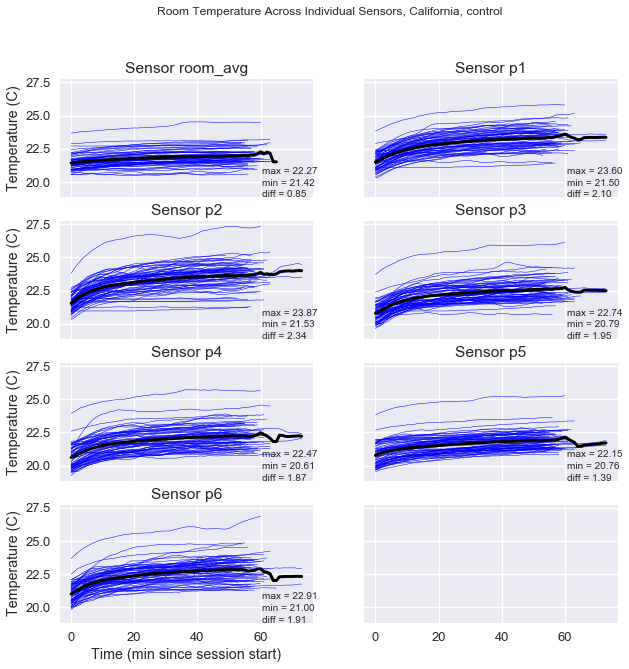

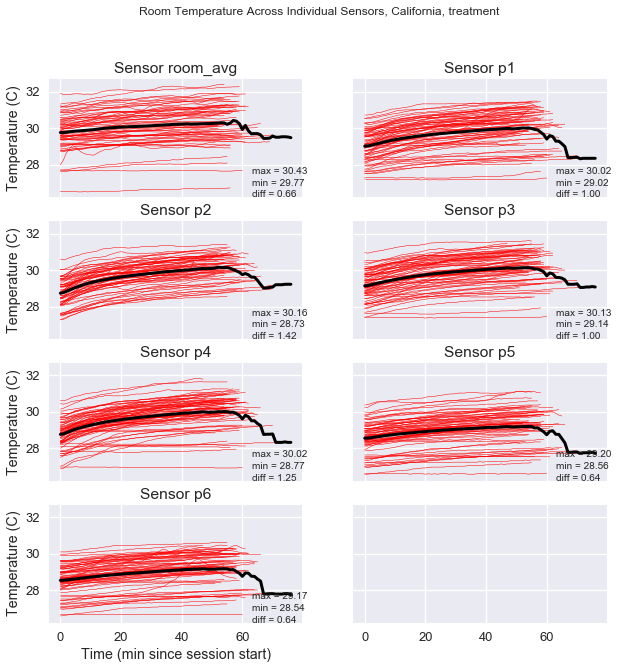

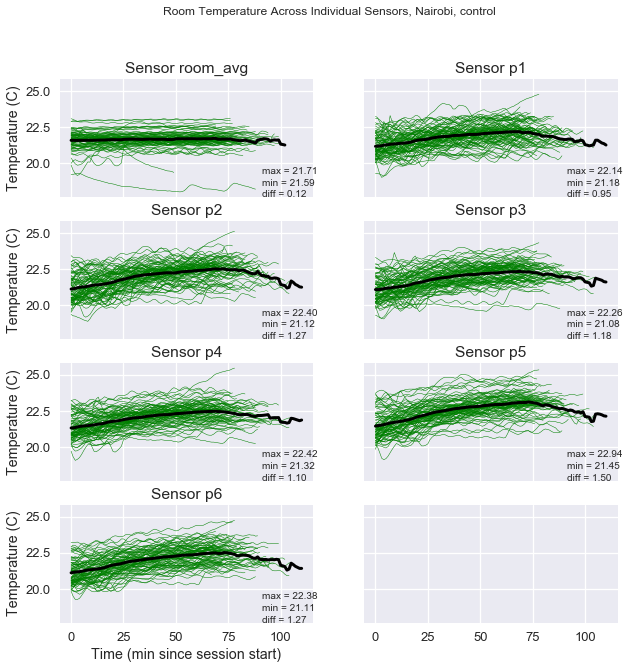

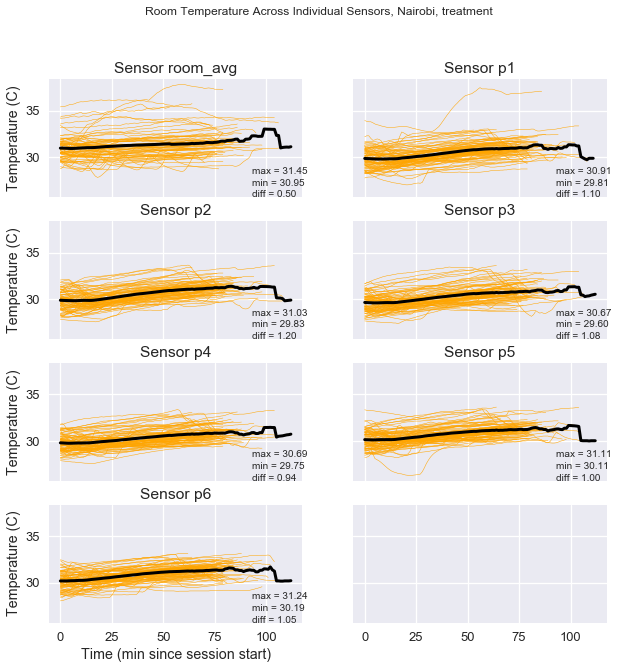

In [48]:
colors = {'California':{'control':'b',
                       'treatment':'r'},
         'Nairobi':{'control':'g',
                   'treatment':'orange'}}

styles = {'California':'-',
         'Nairobi':'-'}
lines = []

for site in ['California','Nairobi']:
    for grp in ['control','treatment']:
        fig,axs = plt.subplots(4,2, figsize = (10,10), sharex=True, sharey=True)
        fig.suptitle('Room Temperature Across Individual Sensors, {}, {}'.format(site,grp))
        
        for ix,sensor in enumerate(['room_avg'] + ['p{}'.format(i) for i in range(1,7)]):
            y = int(ix/2)
            x = ix % 2
            ax = axs[y,x]
            this_df = ts_dfs[site][grp][sensor]
            this_df.plot(legend=False, style = styles[site], color = colors[site][grp],
                                   linewidth = .5, ax=ax)
            mean = this_df.mean(axis=1)
            count = this_df.count(axis=1)
            mean_of_means = (mean*count).sum()/count.sum()
            this_min = mean.loc[:50].min()
            this_max = mean.loc[:60].max()
            line, = ax.plot(mean, color = 'k', linewidth = 3, label = '{}, {} (mean = {:.2f})'.format(
                site,grp,mean_of_means))
            lines.append(line)
            ax.set_ylabel('Temperature (C)')
            ax.set_xlabel('Time (min since session start)')
            ax.set_title('Sensor {}'.format(sensor))
            ax.text(.8,.1,'min = {:.2f}'.format(this_min), transform = ax.transAxes)
            ax.text(.8,.2,'max = {:.2f}'.format(this_max), transform = ax.transAxes)
            ax.text(.8,.0,'diff = {:.2f}'.format(this_max-this_min), transform = ax.transAxes)
            
        fig.savefig('../../results/figures/main_experiment/spaghetti_temps_all_sens_{}_{}.png'.format(site,grp))

### Plots of average of room temp sensors

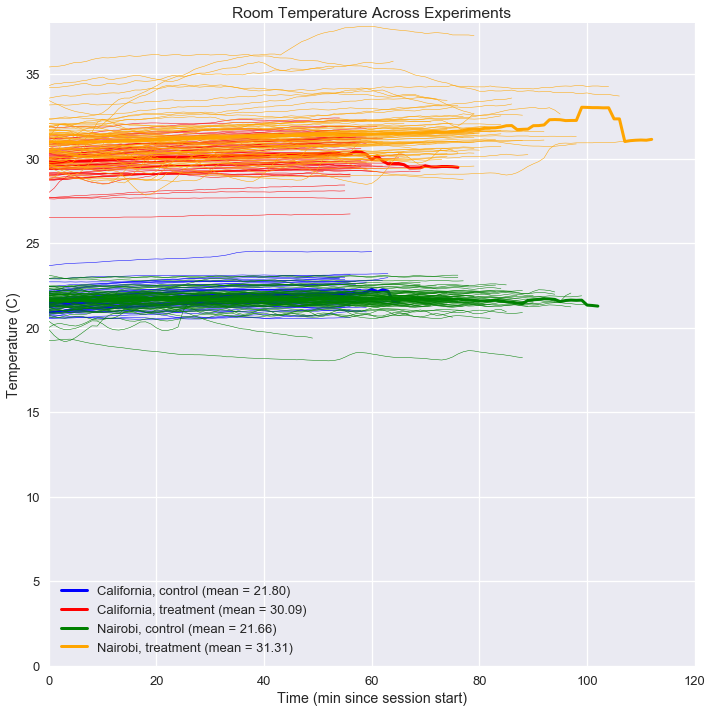

In [8]:
colors = {'California':{'control':'b',
                       'treatment':'r'},
         'Nairobi':{'control':'g',
                   'treatment':'orange'}}

styles = {'California':'-',
         'Nairobi':'-'}
lines = []
fig,ax = plt.subplots(1, figsize = (10,10))
for site in ['California','Nairobi']:
    for grp in ['control','treatment']:
        this_df = ts_dfs[site][grp]['room_avg']
        this_df.plot(legend=False, style = styles[site], color = colors[site][grp],
                               linewidth = .5, ax=ax)
        mean = this_df.mean(axis=1)
        count = this_df.count(axis=1)
        mean_of_means = (mean*count).sum()/count.sum()
        line, = ax.plot(mean, color = colors[site][grp], linewidth = 3, label = '{}, {} (mean = {:.2f})'.format(
            site,grp,mean_of_means))
        lines.append(line)
            
            
plt.title('Room Temperature Across Experiments')
plt.ylabel('Temperature (C)')
plt.xlabel('Time (min since session start)')

plt.xlim(0,120)
plt.ylim(0,38)
plt.legend(handles = lines)
plt.tight_layout()
plt.savefig('../../results/figures/main_experiment/spaghetti_temps.png')

### Watercolor plot for session temps

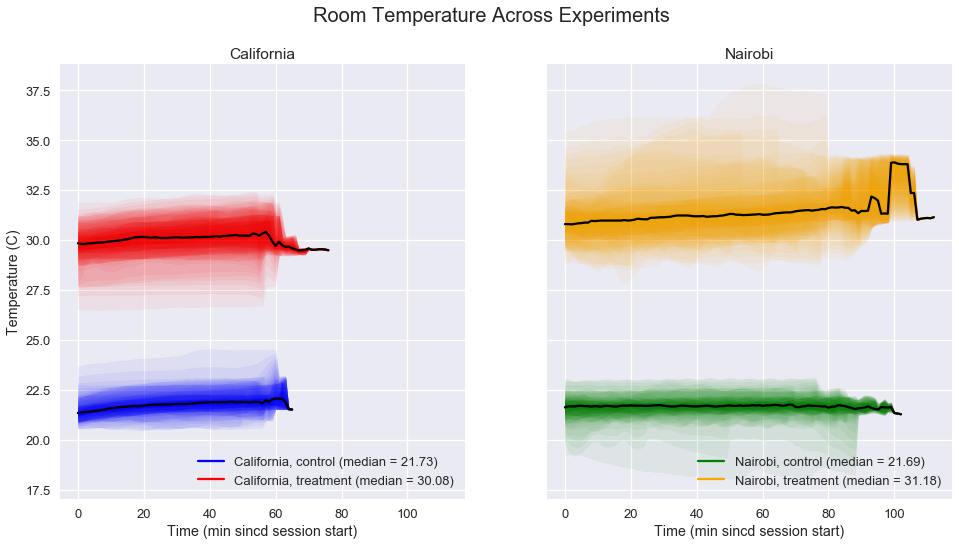

In [46]:
fig,axs = plt.subplots(1,2, figsize = (16,8),sharex=True,sharey=True)
fig.suptitle('Room Temperature Across Experiments',fontsize=20)

axs[0].set_ylabel('Temperature (C)')
for six,site in enumerate(['California','Nairobi']):
    lines = []
    ax = axs[six]
    ax.set_title(site)
    ax.set_xlabel('Time (min sincd session start)')
    for grp in ['control','treatment']:
        this_df = ts_dfs[site][grp]['room_avg']
        med = this_df.quantile(q=.5,axis=1)
        count = this_df.count(axis=1)
        mean_of_med = (med*count).sum()/count.sum()
        line, = ax.plot(med, color = colors[site][grp], label = '{}, {} (median = {:.2f})'.format(
            site,grp,mean_of_med))
        lines.append(line)
        ax.plot(med,color = 'k')
        for i in np.arange(0,.5,.01):
            this_quantile_low = this_df.quantile(q=i,axis=1)
            this_quantile_high = this_df.quantile(q=1-i,axis=1)
            ax.fill_between(this_quantile_low.index, this_quantile_low, this_quantile_high, alpha=.05,color = colors[site][grp])
        ax.legend(handles = lines,loc='lower right')

fig.savefig('../../results/figures/main_experiment/watercolor_temps.png')

### Calculate average temps for each experiement using room temp sensors and individual sensors

In [80]:
cols = ['T_in_mean'] + ['T_p{}_mean'.format(i) for i in range(1,7)]
session_df_berk = pd.read_csv(save_fpath_berk, index_col=[2]).loc[:,cols]
session_df_bus = pd.read_csv(save_fpath_bus, index_col=[2]).loc[:,cols]
sess_dfs = {'California':session_df_berk,
           'Nairobi':session_df_bus}

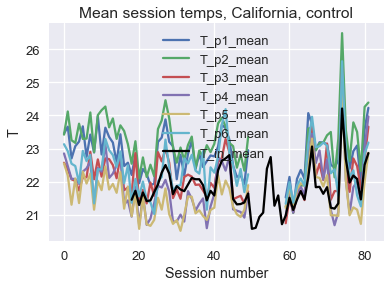

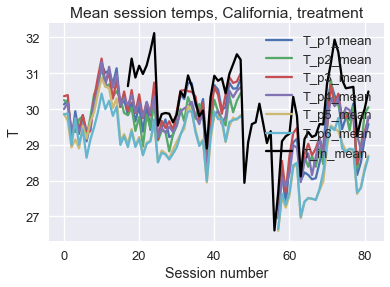

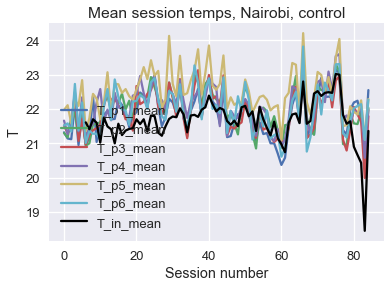

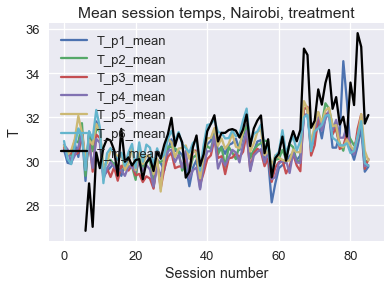

In [81]:
for site in ['California','Nairobi']:
    for ix,grp in enumerate(['control','treatment']):
        treated = sess_dfs[site].loc[ix,:].reset_index(drop=True)
        treated.iloc[:,1:].plot()
        treated.iloc[:,0].plot(color='k',legend=True)
        plt.title('Mean session temps, {}, {}'.format(site,grp))
        plt.ylabel('T')
        plt.xlabel('Session number')
        plt.savefig('../../results/figures/main_experiment/mean_temps_by_sens_{}_{}.png'.format(site,grp))